# Recurrent Neural Network that we will work with

In [6]:
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch 
import torch.optim as optim 
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.linear_model import LinearRegression
import time
import matplotlib.pyplot as plt 


In [7]:
class baseRNN(nn.Module):
    def __init__(self, d_in: int, d_hidden:int , d_out:int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden), 
            nn.ReLU(),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, d_out)
        )
    
    def forward(self, x):
        return self.net(x)

In [8]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

## Getting the data into the project to make it run

In [5]:
training_data = pd.read_csv('./gnp_data_created.csv')
training_data

,t,dy,S,mu
0,0,1.200000,1,1.1283
1,1,1.100000,1,1.1283
2,2,1.100000,1,1.1283
3,3,1.100000,1,1.1283
4,4,0.635197,1,1.1283
...,...,...,...,...
999996,999996,2.196883,1,1.1283
999997,999997,-0.191009,0,-0.2132
999998,999998,-0.690130,0,-0.2132
999999,999999,0.146808,0,-0.2132


In [7]:
def create_dataloader(series, window_size):
    dy = series.values.astype(np.float32)
    n_samples = len(dy) - window_size

    X = np.array([dy[i:i+window_size] for i in range(n_samples)])
    Y = dy[window_size:]

    X_t = torch.tensor(X)
    Y_t = torch.tensor(Y)

    dataset = TensorDataset(X_t, Y_t)
    loader = DataLoader(dataset, batch_size=512, shuffle=False)
    return loader


In [8]:
WINDOW_SIZE = 4
dy = training_data['dy']
split_idx = int(len(dy) * 0.8)
train_dy = dy.iloc[:split_idx]
val_dy = dy.iloc[split_idx - WINDOW_SIZE:]  # overlap for valid first X

train_loader = create_dataloader(train_dy, window_size=WINDOW_SIZE)
val_loader = create_dataloader(val_dy, window_size=WINDOW_SIZE)

In [9]:
def get_xy_arrays(series, window_size):
    """Returns X, Y numpy arrays for baseline fitting and MSE computation."""
    dy = series.values.astype(np.float32)
    n_samples = len(dy) - window_size
    X = np.array([dy[i:i+window_size] for i in range(n_samples)])
    Y = dy[window_size:]
    return X, Y

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

X_train, Y_train = get_xy_arrays(train_dy, WINDOW_SIZE)
X_val, Y_val = get_xy_arrays(val_dy, WINDOW_SIZE)

# Baseline 1: Predict training mean (naive)
mean_baseline_pred = np.mean(Y_train)
# Baseline 2: AR(4) OLS regression
ar4_model = LinearRegression()
ar4_model.fit(X_train, Y_train)

# Compute baseline MSEs
mean_pred_train = np.full_like(Y_train, mean_baseline_pred)
mean_pred_val = np.full_like(Y_val, mean_baseline_pred)
ar4_pred_train = ar4_model.predict(X_train)
ar4_pred_val = ar4_model.predict(X_val)

mse_mean_train = mse(Y_train, mean_pred_train)
mse_mean_val = mse(Y_val, mean_pred_val)
mse_ar4_train = mse(Y_train, ar4_pred_train)
mse_ar4_val = mse(Y_val, ar4_pred_val)

print("Baseline MSE (predict mean):")
print(f"  Train: {mse_mean_train:.6f}  |  Val: {mse_mean_val:.6f}")
print("AR(4) OLS MSE:")
print(f"  Train: {mse_ar4_train:.6f}  |  Val: {mse_ar4_val:.6f}")

Baseline MSE (predict mean):
  Train: 1.042159  |  Val: 1.048642
AR(4) OLS MSE:
  Train: 0.936244  |  Val: 0.940091


In [10]:
# Baselines ready. Run training cell below, then the comparison cell.

## Developing the training network

In [11]:
RNN = nikkisfirstRNN(d_in=4,d_hidden=256,d_out=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN.parameters(), lr=1e-3)



In [12]:
def compute_nn_mse(model, loader, device):
    """Compute MSE of model on a dataset."""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            total_loss += criterion(out, yb.unsqueeze(1)).item() * xb.size(0)
    return total_loss / len(loader.dataset)

# Training hyperparameters
num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    RNN.train()
    total_loss = 0
    for xb, yb in train_loader:
        start = time.time()
        xb, yb = xb.to(device), yb.to(device)
        yb = yb.unsqueeze(1)

        optimizer.zero_grad()
        out = RNN(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        end = time.time()
        total_loss += loss.item() * xb.size(0)

        # print(f"One batch takes {end-start:.4f} seconds to execute")

    train_loss = total_loss / len(train_loader.dataset)
    val_loss = compute_nn_mse(RNN, val_loader, device)
    if epoch==0 or epoch%10==0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_MSE={train_loss:.6f}, val_MSE={val_loss:.6f}")
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))

mse_nn_train = compute_nn_mse(RNN, train_loader, device)
mse_nn_val = compute_nn_mse(RNN, val_loader, device)


Epoch 1/100: train_MSE=0.927964, val_MSE=0.927006
Epoch 11/100: train_MSE=0.922902, val_MSE=0.927074
Epoch 21/100: train_MSE=0.922609, val_MSE=0.926799
Epoch 31/100: train_MSE=0.922414, val_MSE=0.926726
Epoch 41/100: train_MSE=0.922301, val_MSE=0.926733
Epoch 51/100: train_MSE=0.922214, val_MSE=0.926746
Epoch 61/100: train_MSE=0.922120, val_MSE=0.926786
Epoch 71/100: train_MSE=0.922030, val_MSE=0.926884
Epoch 81/100: train_MSE=0.921972, val_MSE=0.926919
Epoch 91/100: train_MSE=0.921887, val_MSE=0.927005


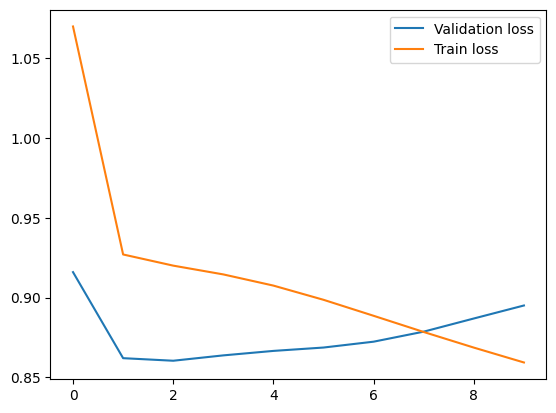

In [65]:
plt.plot(val_losses, label='Validation loss')
plt.plot(train_losses, label='Train loss')

plt.legend()
plt.show()

In [68]:
results = pd.DataFrame({
    'Model': ['Predict mean (naive)', 'AR(4) OLS', 'Neural Network'],
    'Train MSE': [mse_mean_train, mse_ar4_train, mse_nn_train],
    'Val MSE': [mse_mean_val, mse_ar4_val, mse_nn_val],
})
results['Train MSE'] = results['Train MSE'].round(6)
results['Val MSE'] = results['Val MSE'].round(6)
print(results.to_string(index=False))

# Improvement over baselines
print("\n--- NN improvement over baselines (lower is better) ---")
print(f"vs Mean baseline - Train: {(1 - mse_nn_train/mse_mean_train)*100:.1f}% lower MSE, Val: {(1 - mse_nn_val/mse_mean_val)*100:.1f}% lower MSE")
print(f"vs AR(4) OLS     - Train: {(1 - mse_nn_train/mse_ar4_train)*100:.1f}% lower MSE, Val: {(1 - mse_nn_val/mse_ar4_val)*100:.1f}% lower MSE")

               Model  Train MSE  Val MSE
Predict mean (naive)   1.036791 0.965563
           AR(4) OLS   0.937768 0.866496
      Neural Network   0.845474 0.902998

--- NN improvement over baselines (lower is better) ---
vs Mean baseline - Train: 18.5% lower MSE, Val: 6.5% lower MSE
vs AR(4) OLS     - Train: 9.8% lower MSE, Val: -4.2% lower MSE
